In [1]:
library(tidyverse)
library(grid)

source('../utils/plottingUtilities.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# this is the original late data
# stored in "late"
load('../data/lateData.Rdata')

# Plot dictionaries

## The original staNMF fit  

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

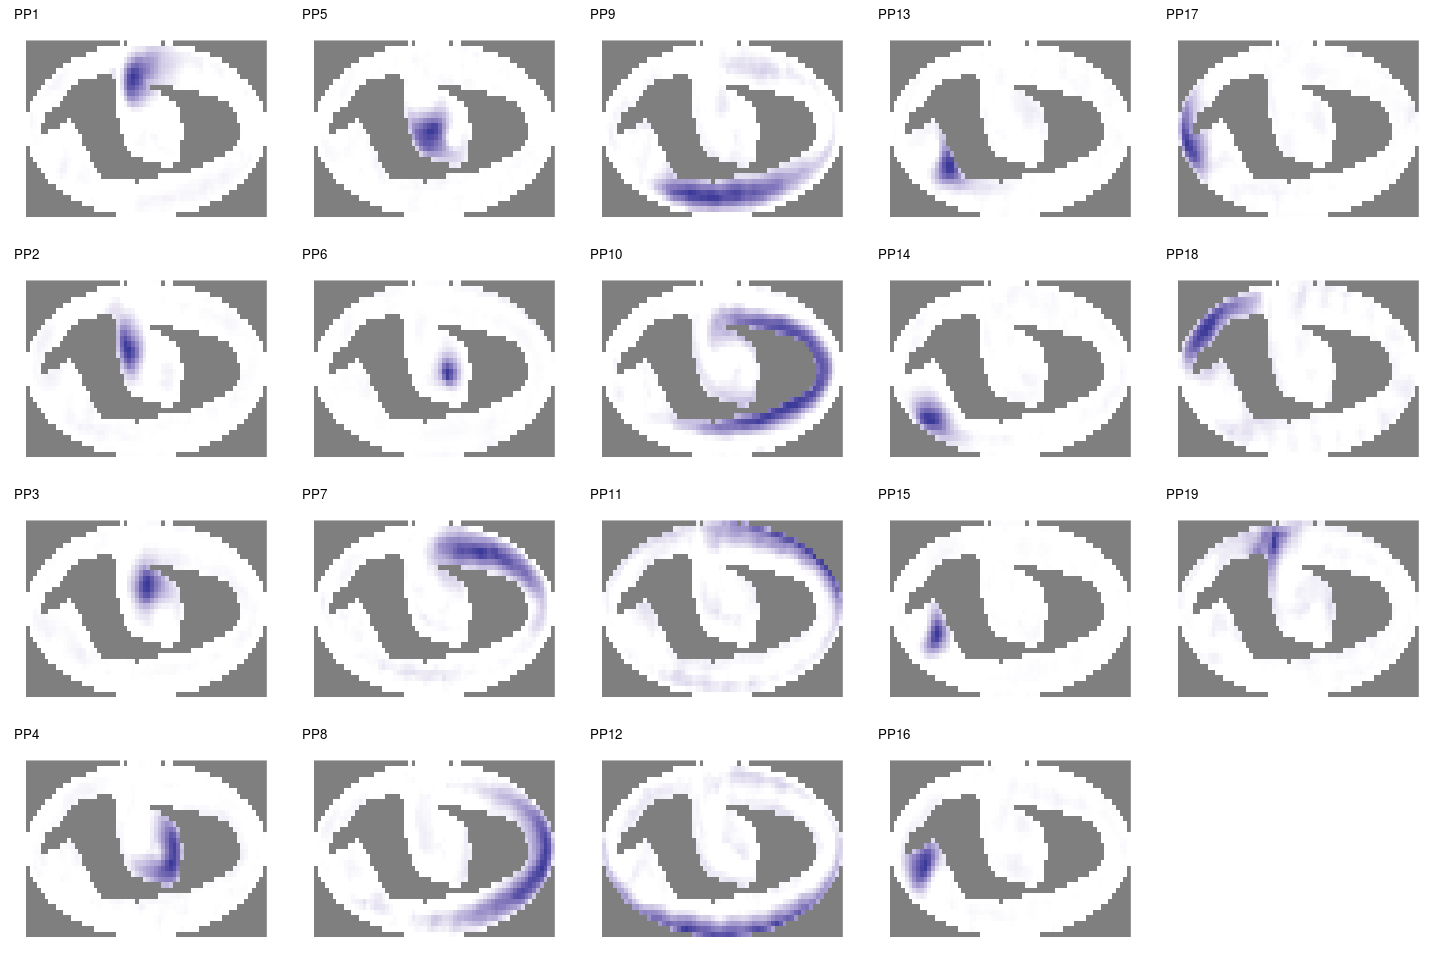

In [3]:
# NOTE PPs are column ordered
options(repr.plot.width = 12, repr.plot.height = 8)
plot_all_PPs(late$dict, late$template)

# get genes with replicates 

In [4]:
table_genes <- table(late$gene.names)
repeated_genes <- names(table_genes)[table_genes > 1]
n_repeated_genes <- length(repeated_genes)

In [5]:
sum(table_genes > 1)

[1] 148

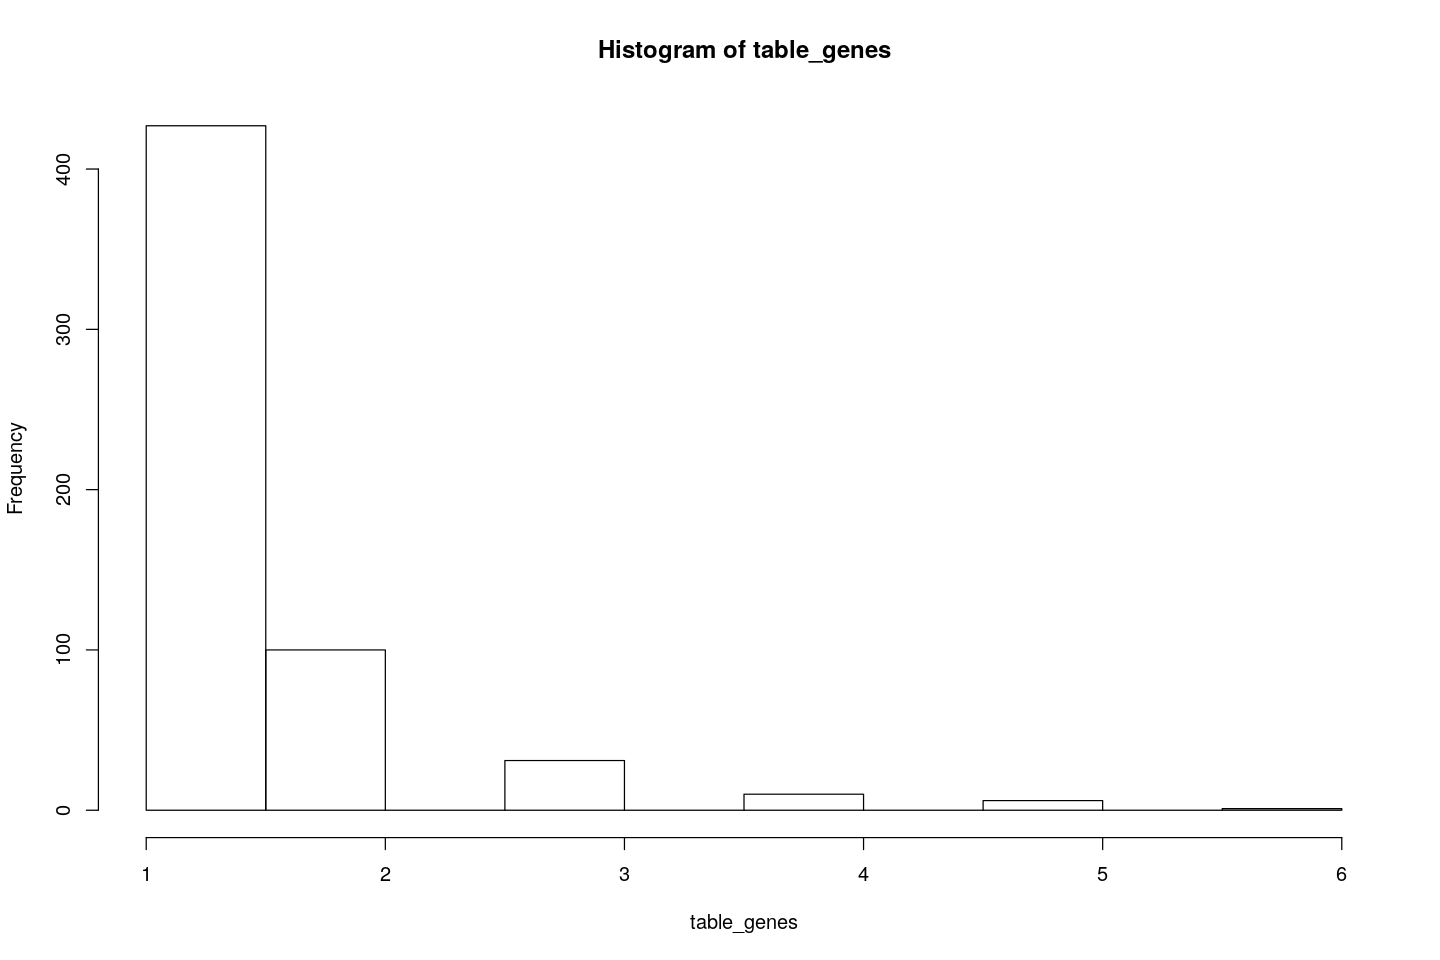

In [6]:
# distribution of number of replicates
hist(table_genes)

# get correlations

In [7]:
get_all_pairwise_correlations <- function(x){
    # x is matrix of pixel values
    # each column is a vector of pixel values corresponding to a replicate
    # returns all pairwise correlations

    correlations <- cor(x)
    upper_triangular_indx <- row(correlations) <= (col(correlations) - 1)

    return(correlations[upper_triangular_indx])
}


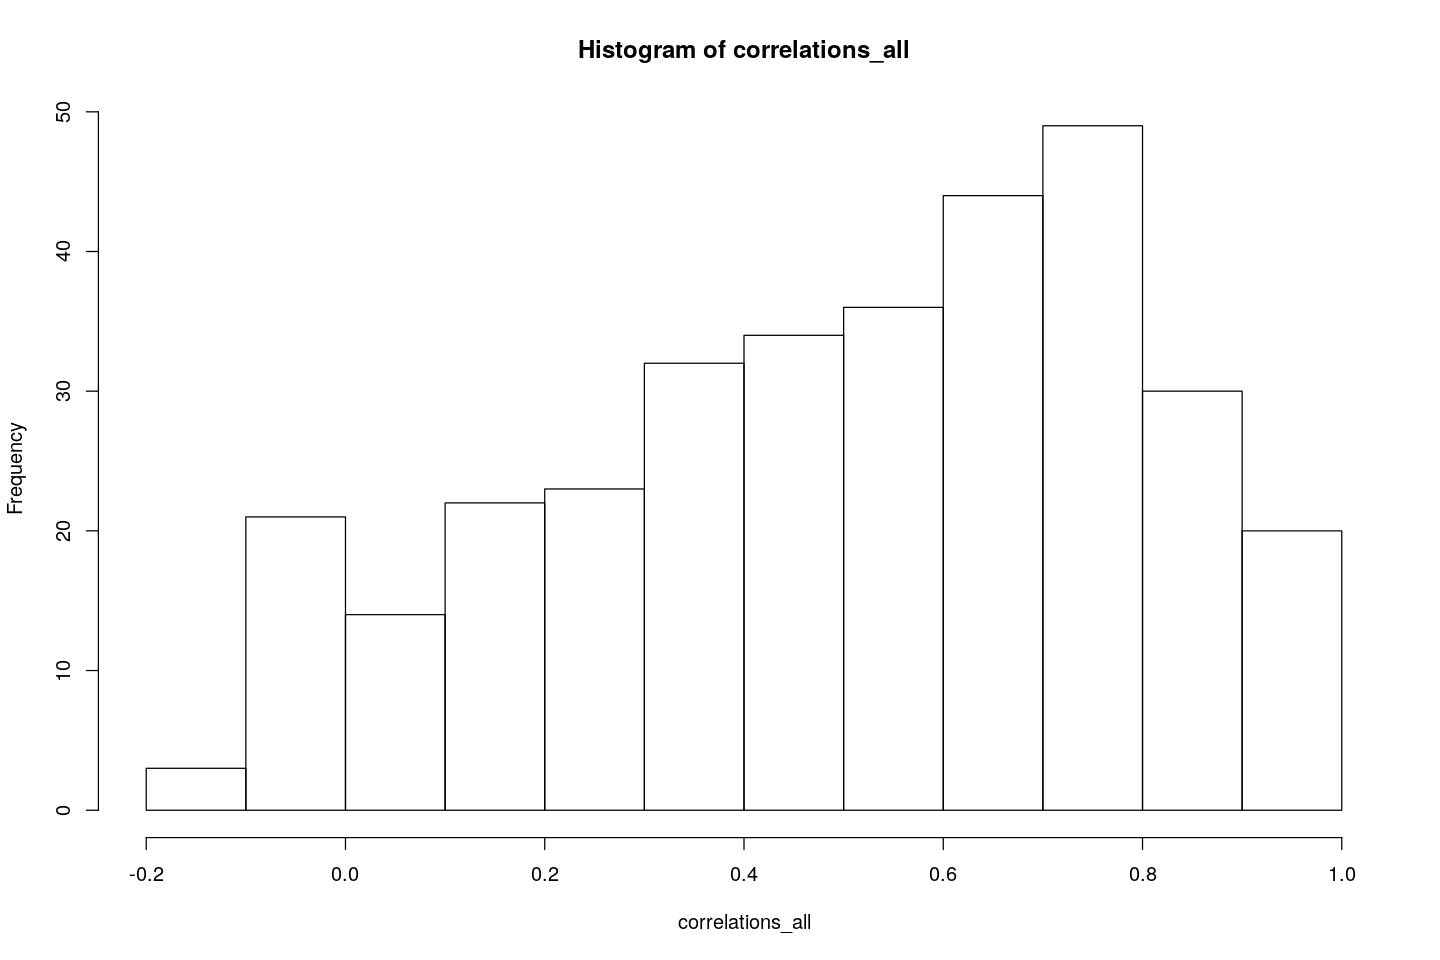

In [8]:
n_repeated_genes <- length(repeated_genes)

correlations_all <- c()

for(i in 1:n_repeated_genes){
    x <- late$x[, colnames(late$x) == repeated_genes[i]]
    
    stopifnot(dim(x)[2] > 1) # check gene is actually repeated
    
    correlations_all <- c(correlations_all, get_all_pairwise_correlations(x))
}


hist(correlations_all)

# Pick out problematic replicates

In [9]:
# pick a threshold 
thresh <- 0.5

In [10]:
which_problematic <- c()
for(i in 1:n_repeated_genes){
    x <- late$x[, colnames(late$x) == repeated_genes[i]]
    
    stopifnot(dim(x)[2] > 1) # check gene is actually repeated
    
    correlations <- get_all_pairwise_correlations(x)
    
    if(any(correlations < thresh)){
        which_problematic <- c(which_problematic, repeated_genes[i])
    }
}


In [11]:
which_problematic

[1] "Aldh"      "Alhambra"  "Ance"      "aret"      "brk"       "btn"      
 [7] "CG10053"   "CG12489"   "CG12744"   "CG12909"   "CG13624"   "CG1598"   
[13] "CG3184"    "CG3249"    "CG3838"    "CG4854"    "CG5888"    "CG6070"   
[19] "CG6206"    "CG6563"    "CG8066"    "CG9663"    "cic"       "comm2"    
[25] "disco"     "Dp"        "dpn"       "Dr"        "E(spl)"    "ebi"      
[31] "en"        "esg"       "eya"       "gcm"       "Grip"      "HGTX"     
[37] "HLHm5"     "ImpE2"     "ind"       "inx2"      "kni"       "l(3)82Fd" 
[43] "l(3)IX-14" "lab"       "Lac"       "loner"     "mael"      "Mef2"     
[49] "Mes2"      "Mipp1"     "Nap1"      "nerfin-1"  "noc"       "nrv2"     
[55] "Optix"     "Oscillin"  "otp"       "pnt"       "prd"       "Pros54"   
[61] "rib"       "sc"        "slp1"      "srp"       "su(r)"     "Sulf1"    
[67] "term"      "toy"       "ttk"       "tup"       "twi"       "Ubx"      
[73] "unpg"

In [12]:
sum(table_genes[names(table_genes) %in% which_problematic] == 3)

[1] 18

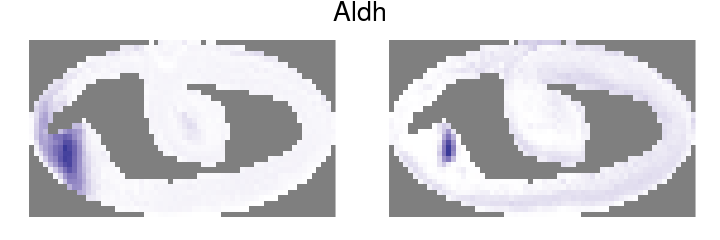

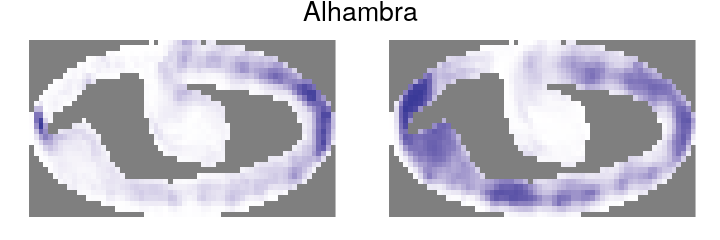

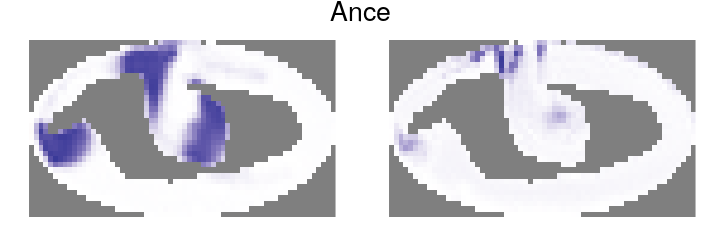

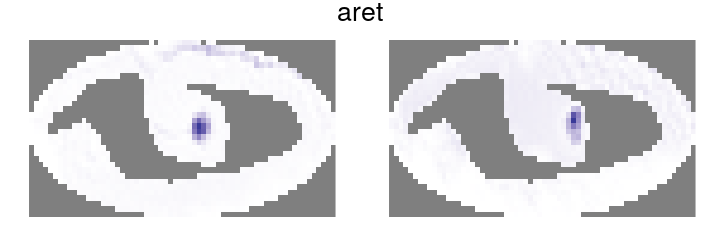

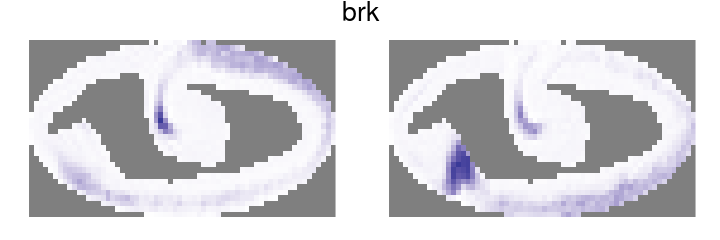

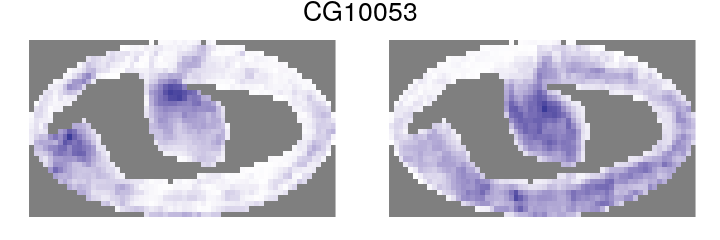

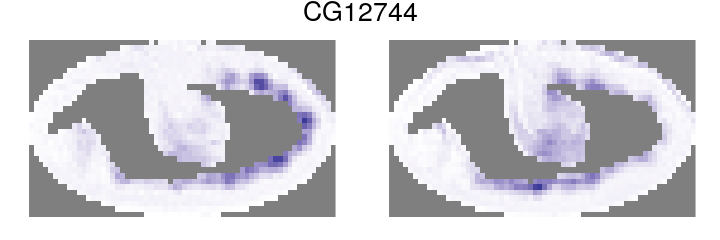

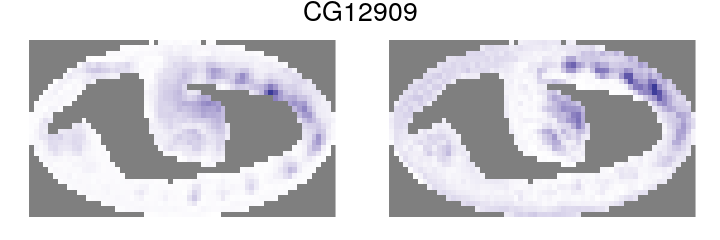

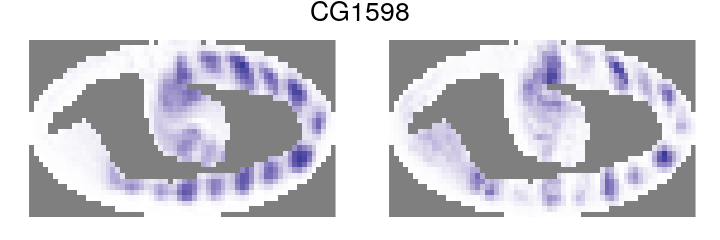

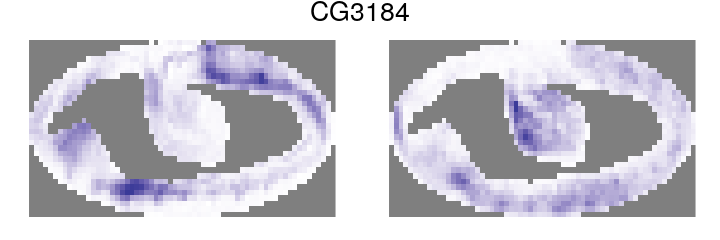

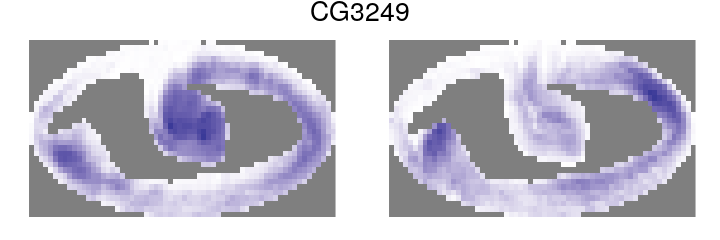

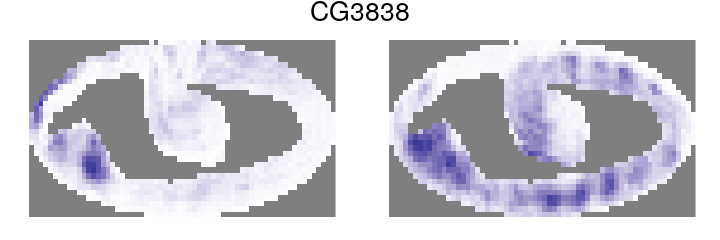

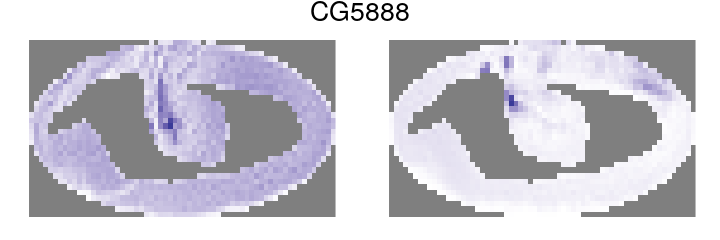

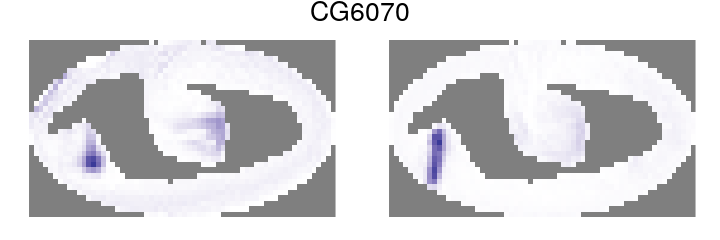

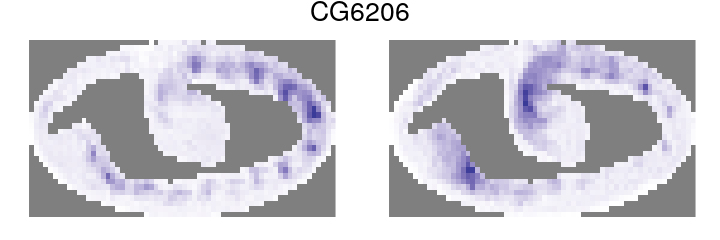

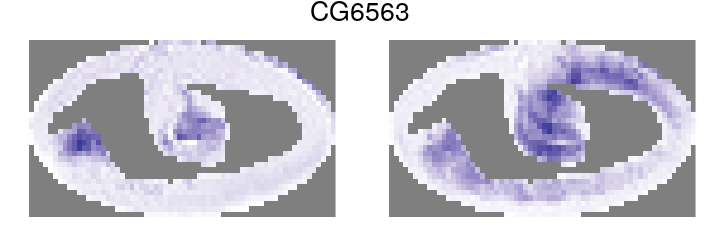

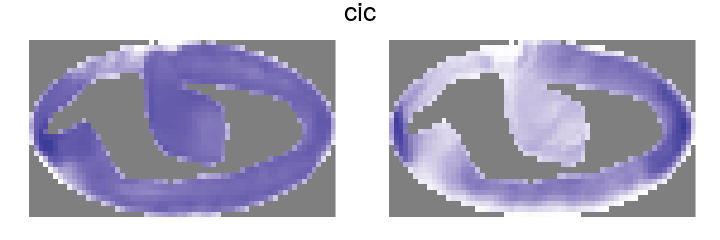

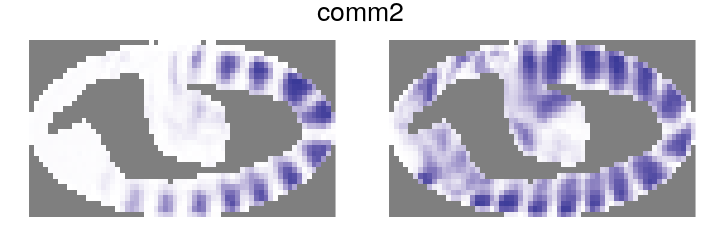

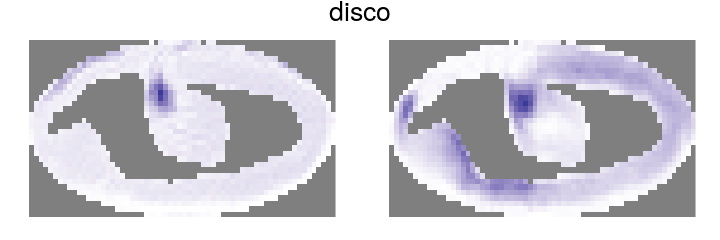

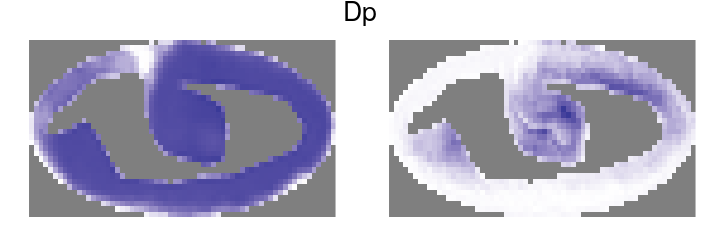

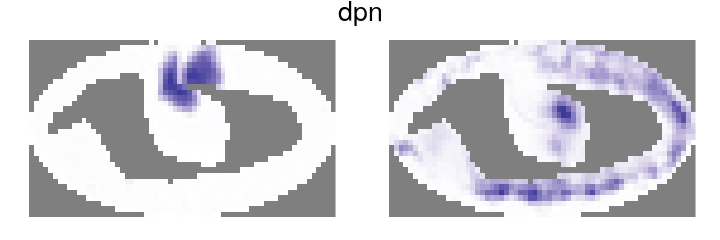

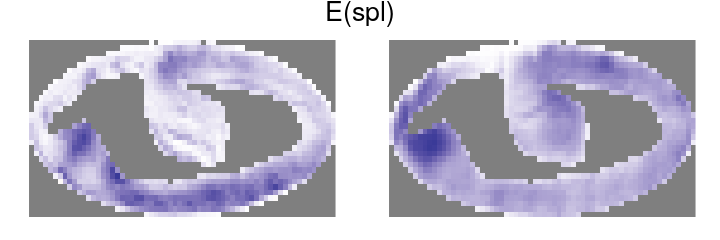

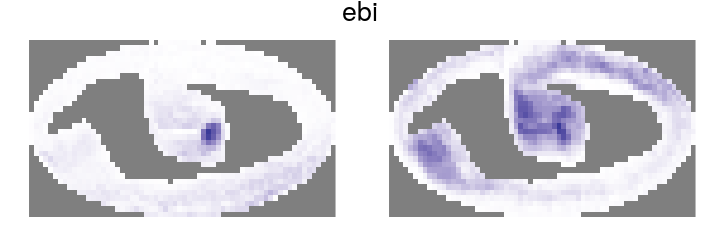

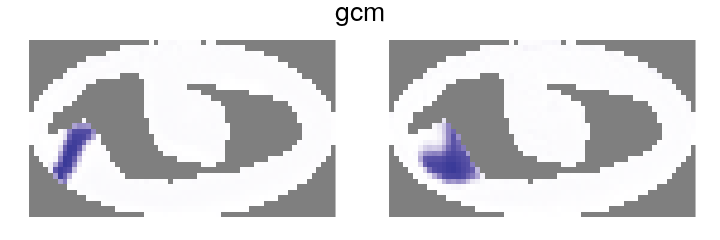

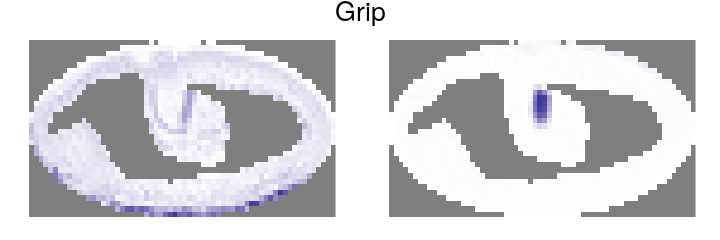

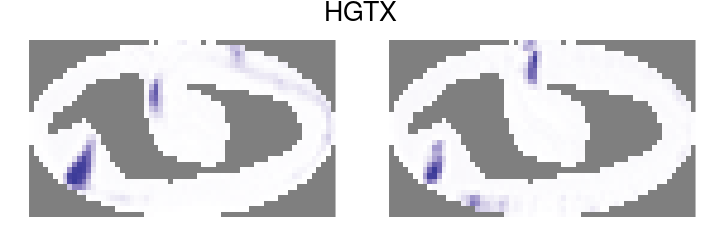

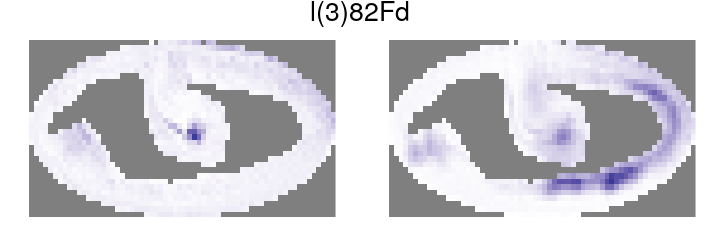

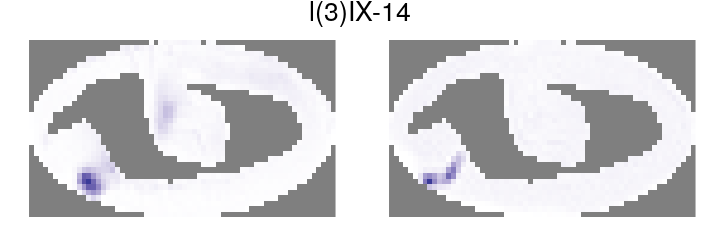

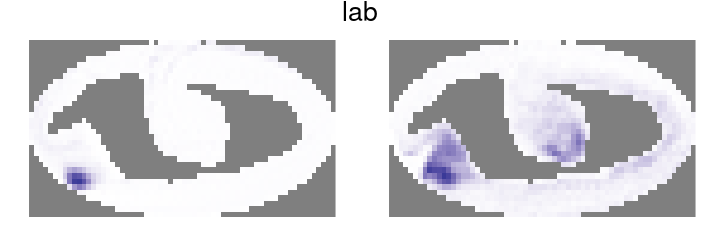

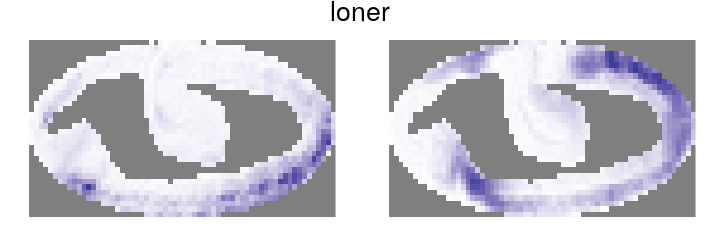

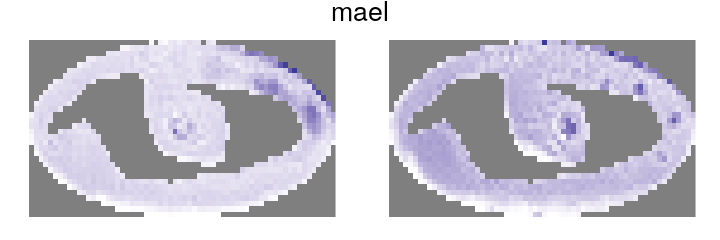

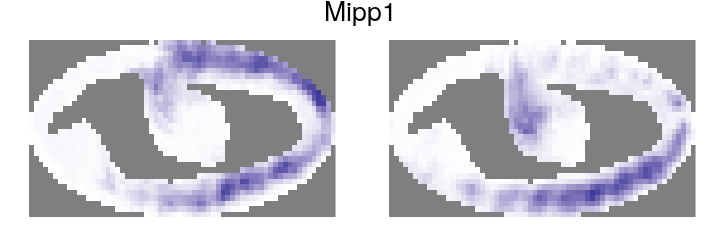

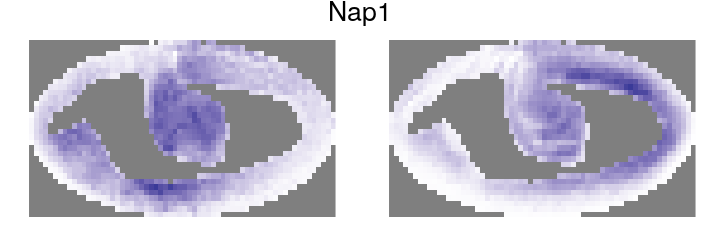

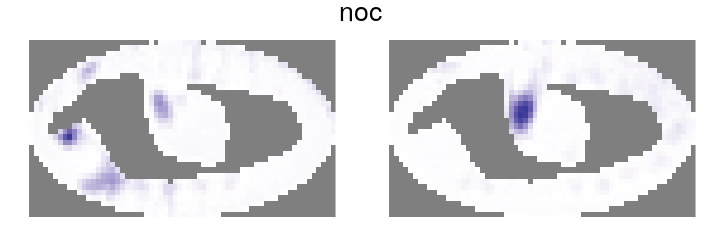

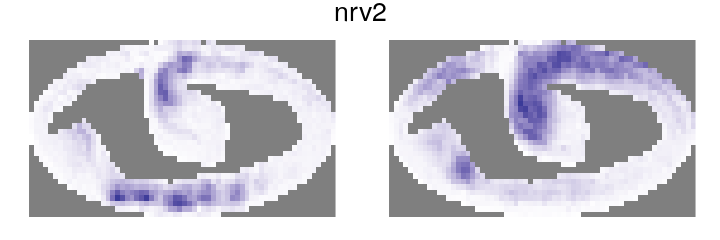

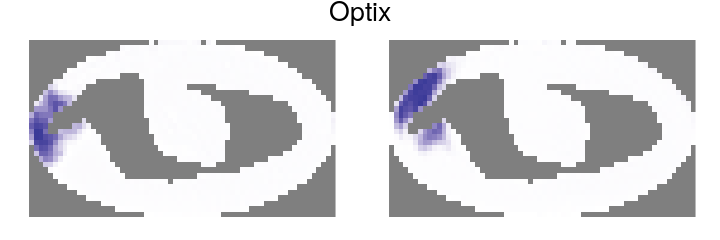

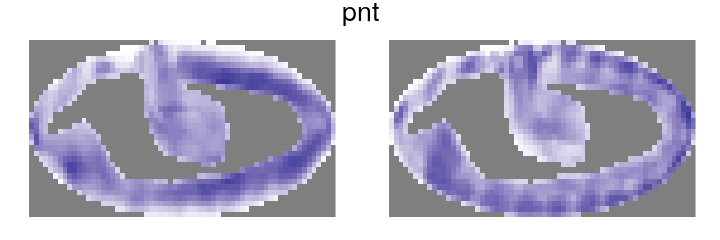

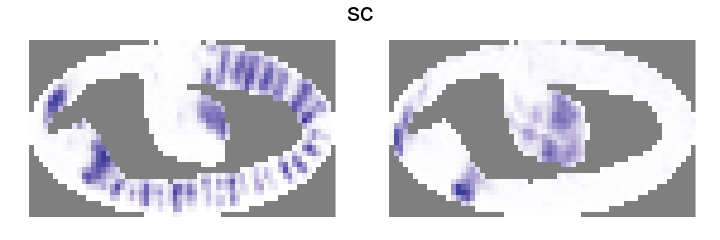

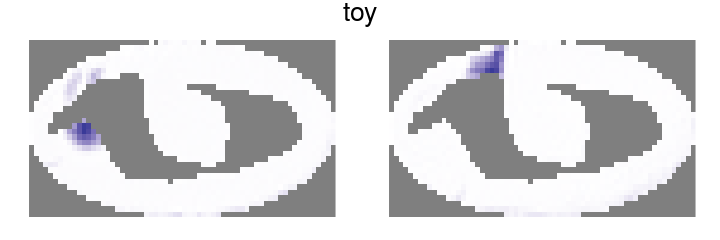

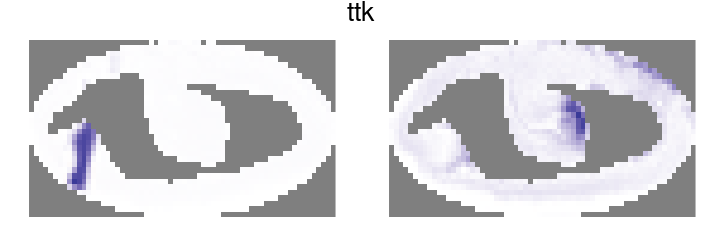

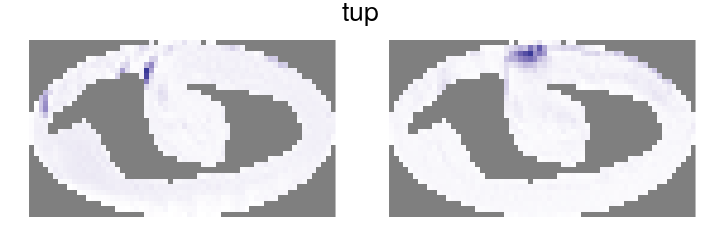

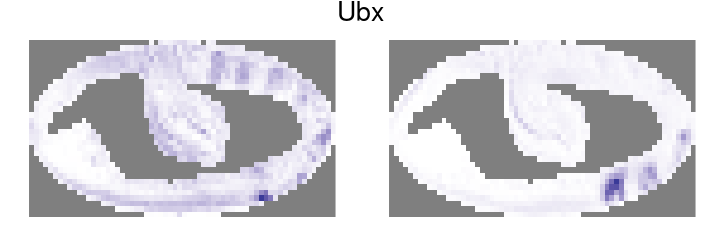

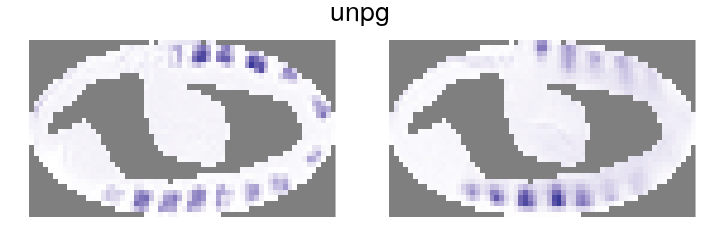

In [13]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) > 2){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 6, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


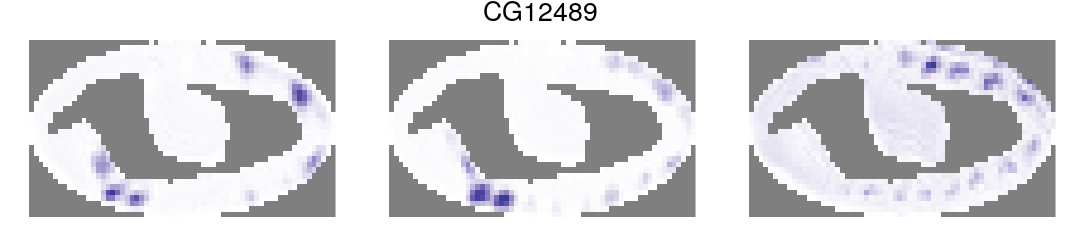

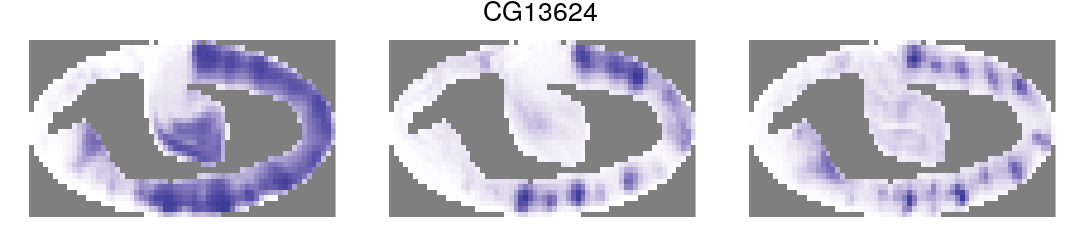

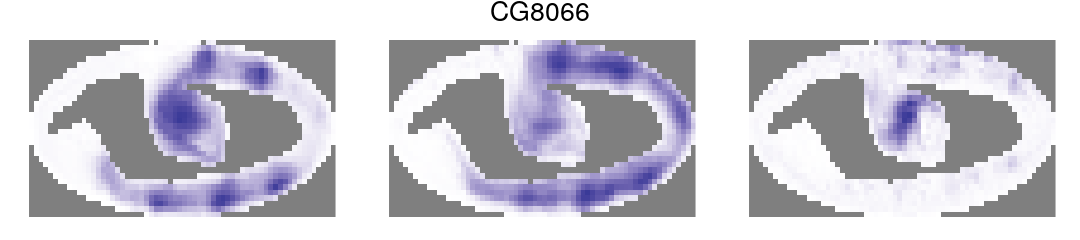

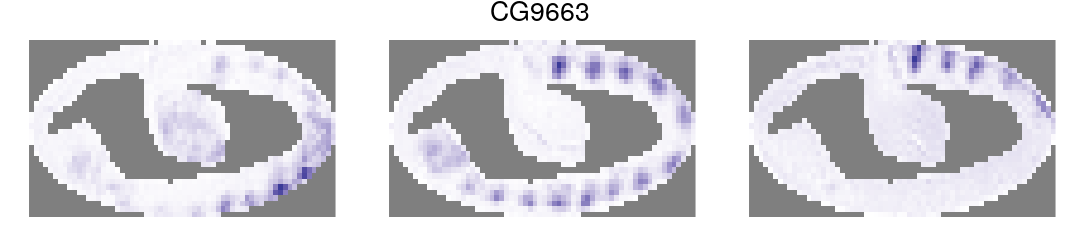

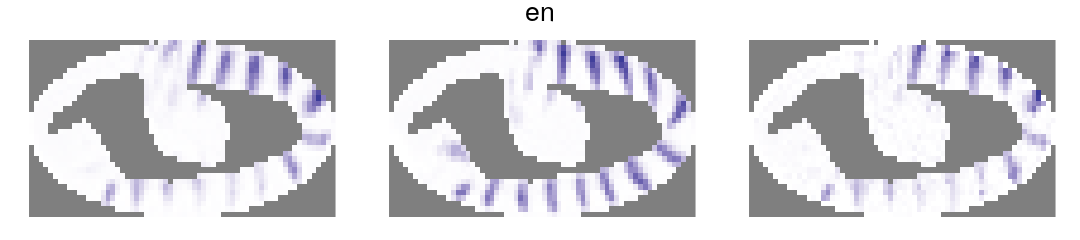

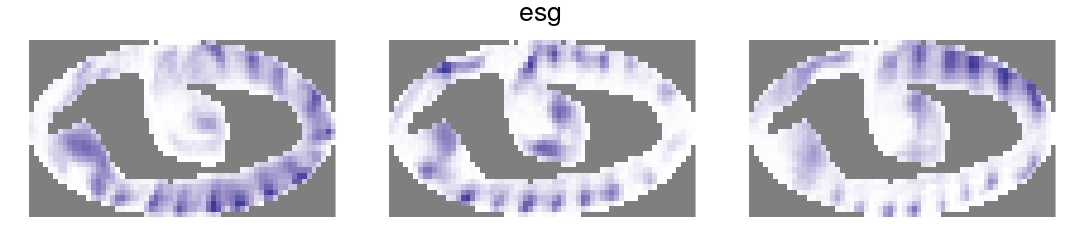

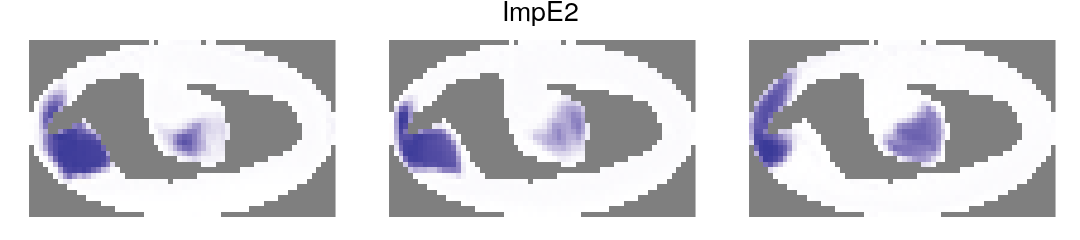

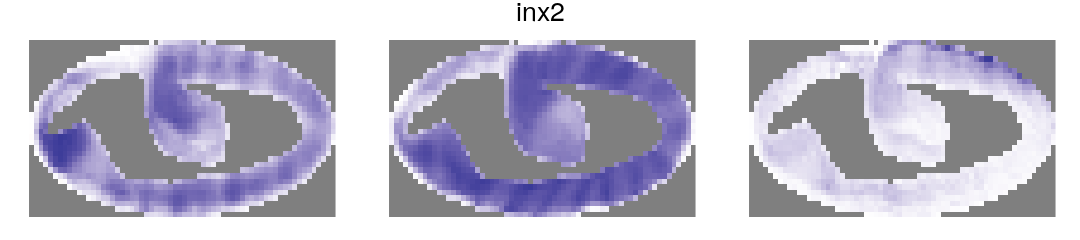

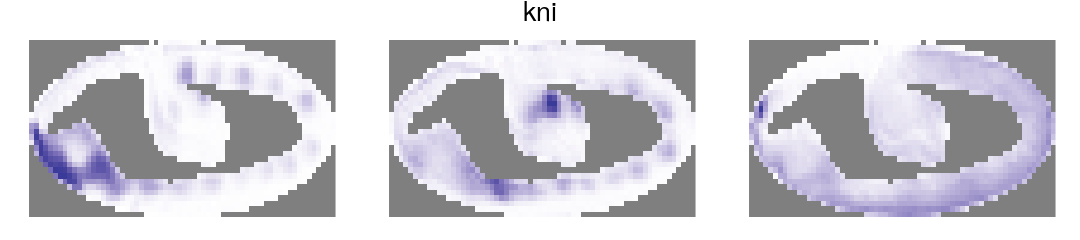

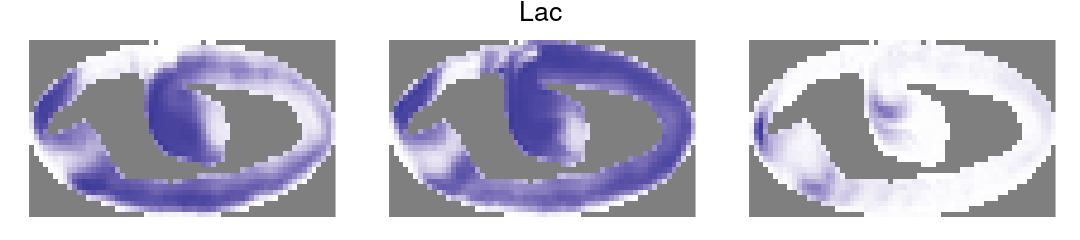

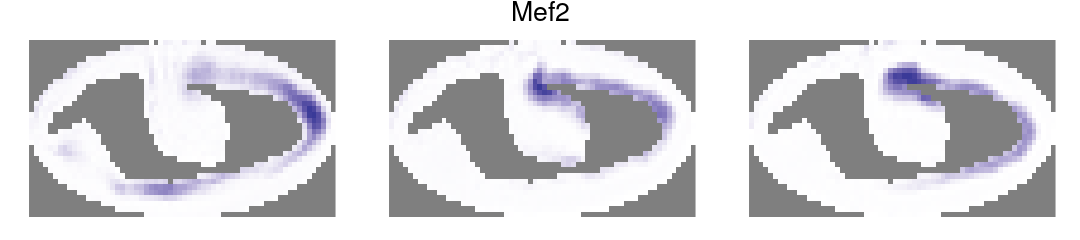

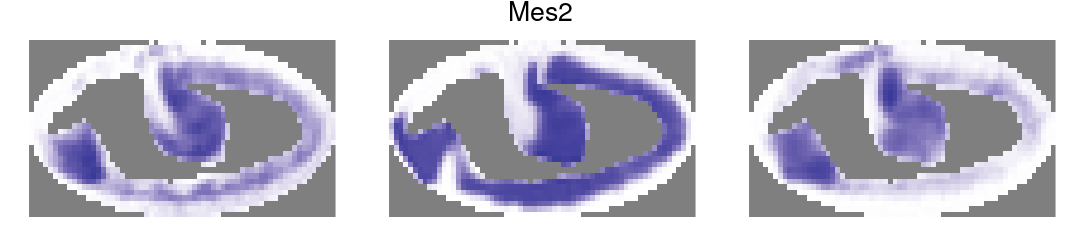

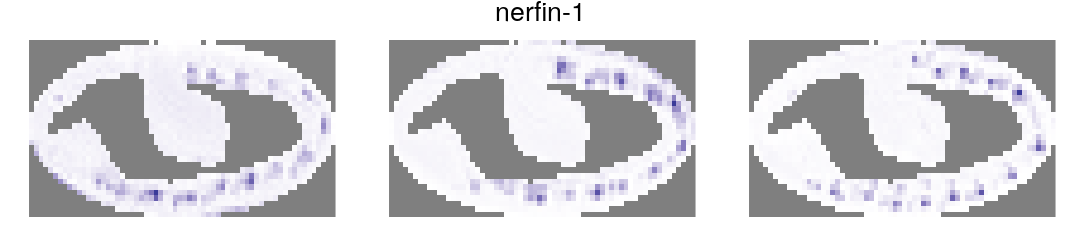

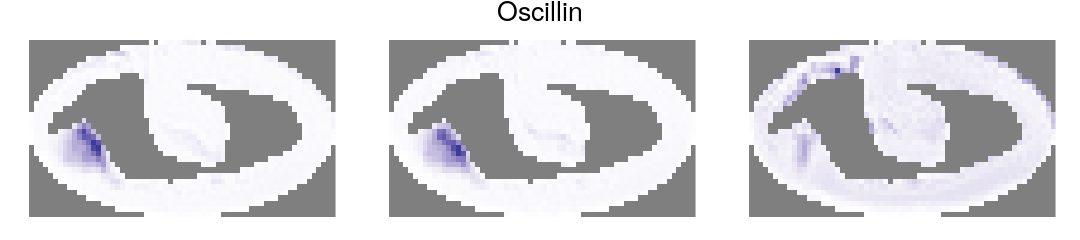

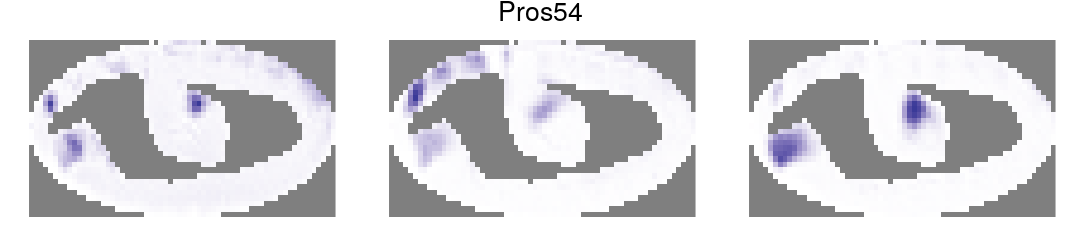

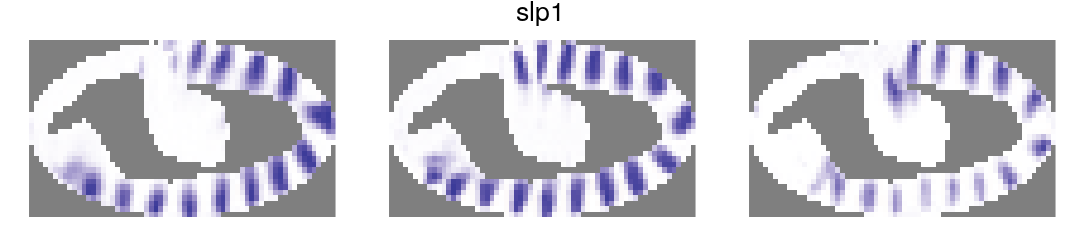

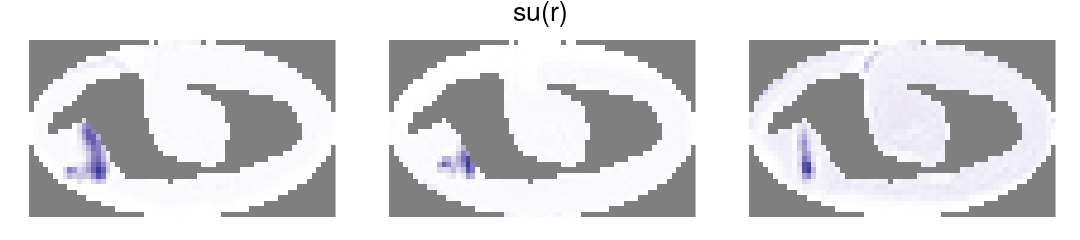

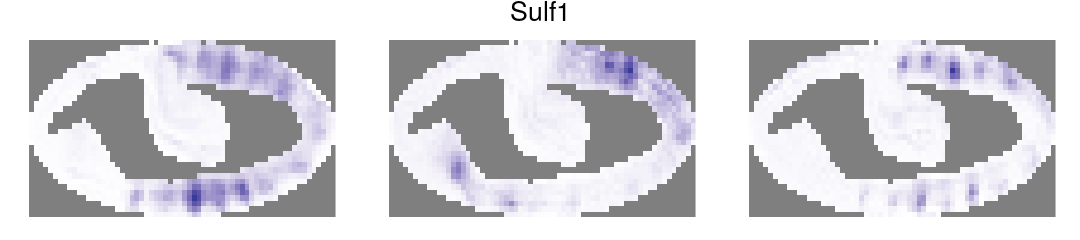

In [14]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 3){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 9, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


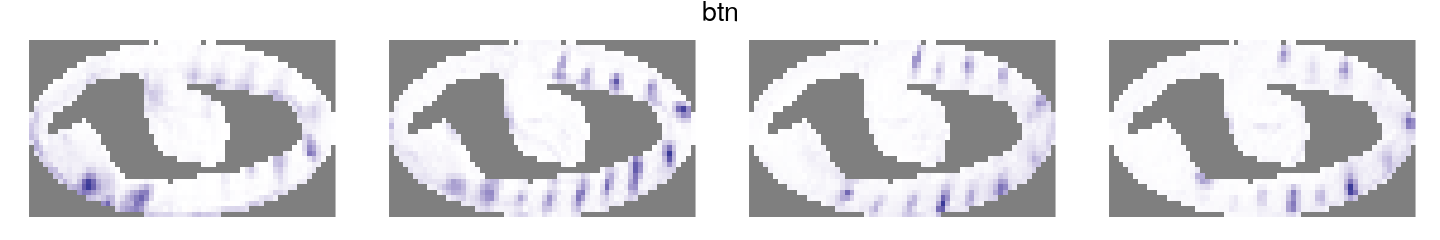

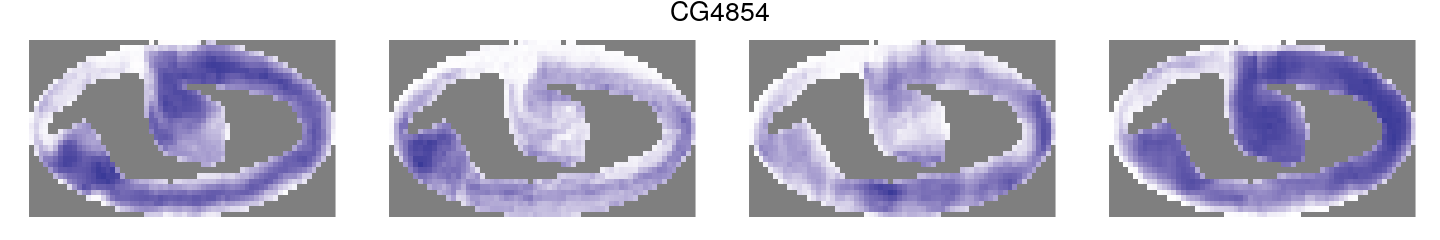

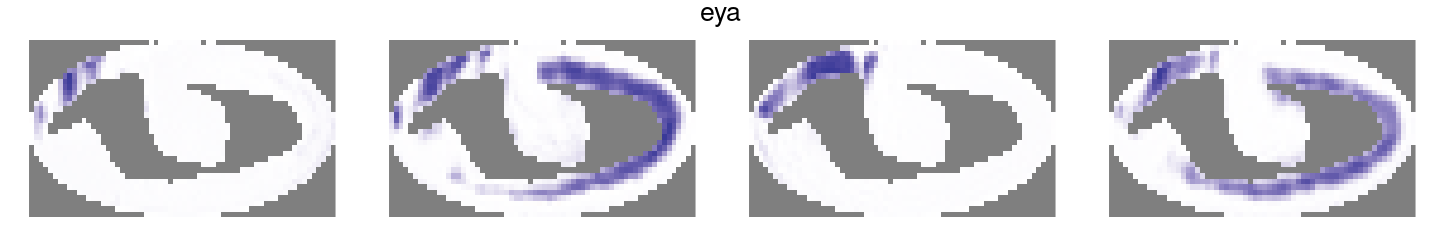

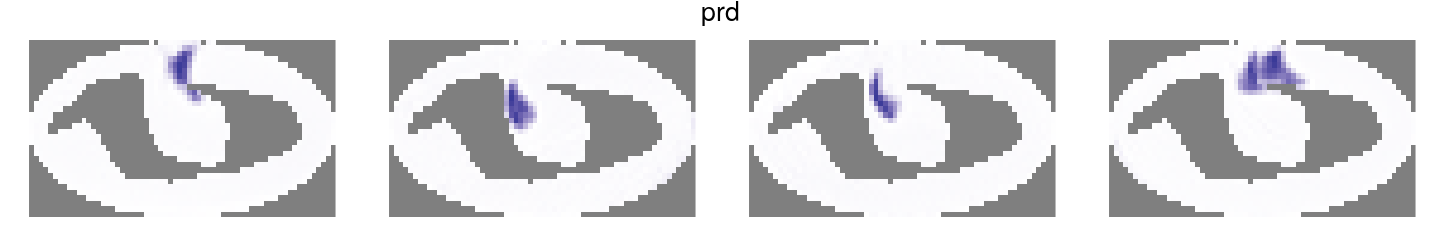

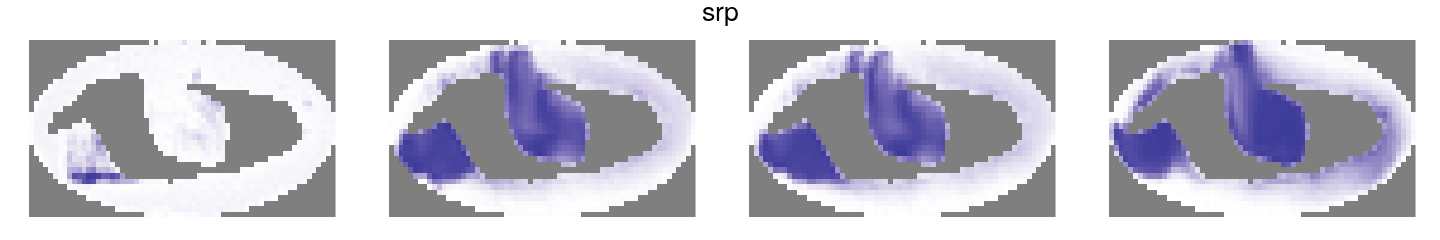

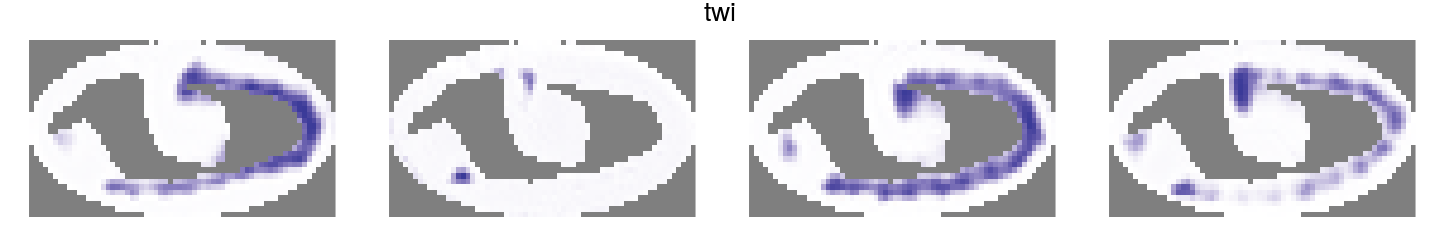

In [15]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 4){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 12, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


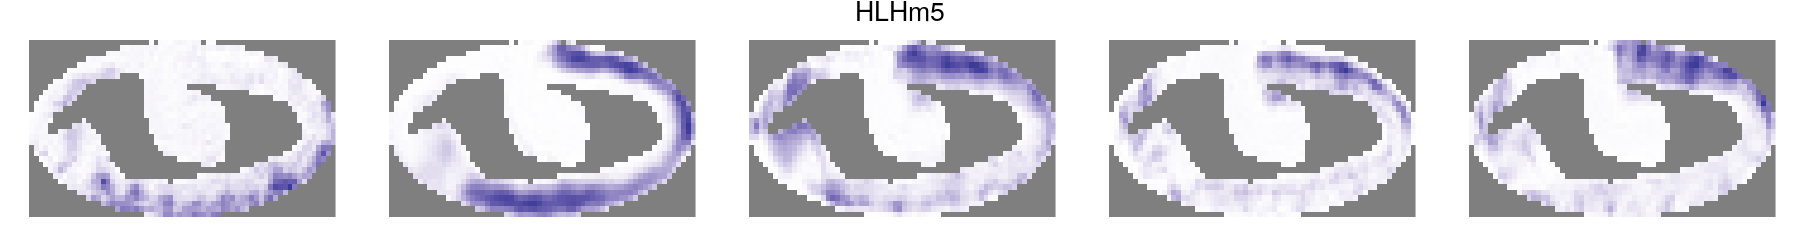

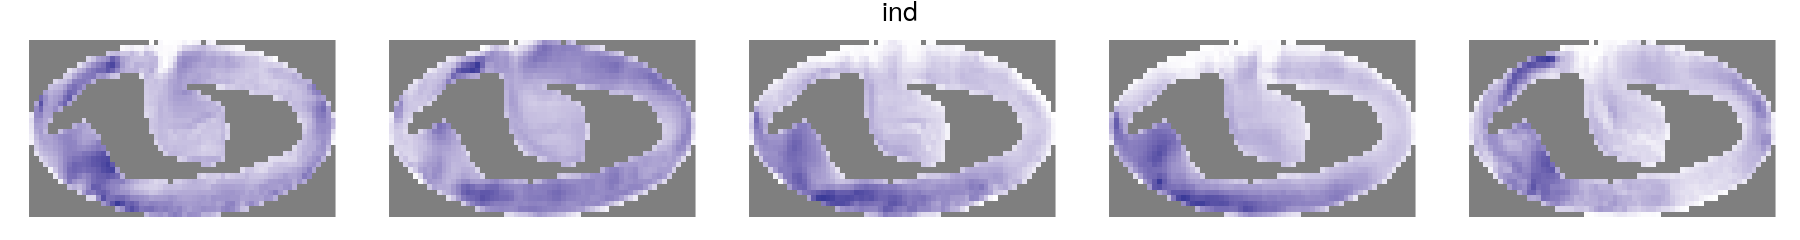

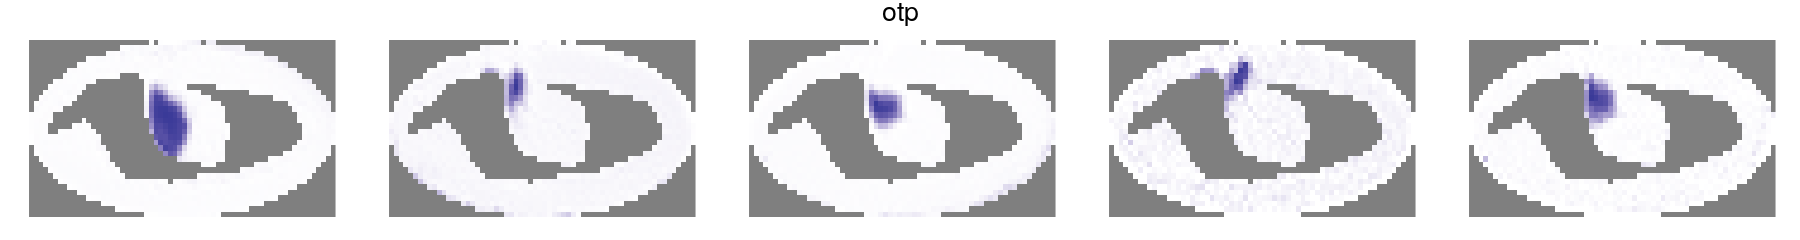

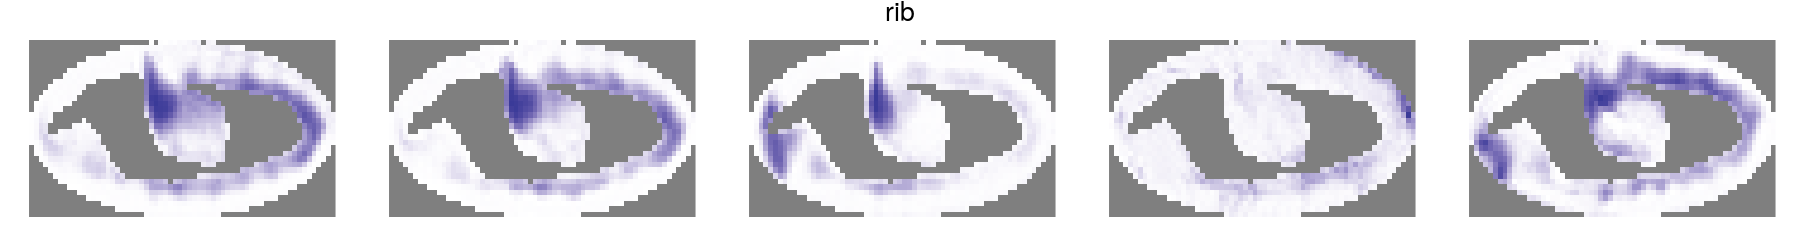

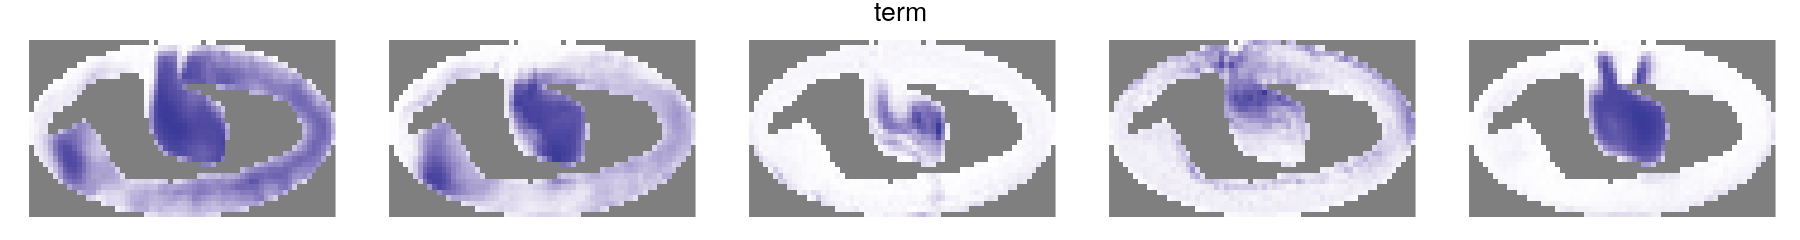

In [16]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 5){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 15, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


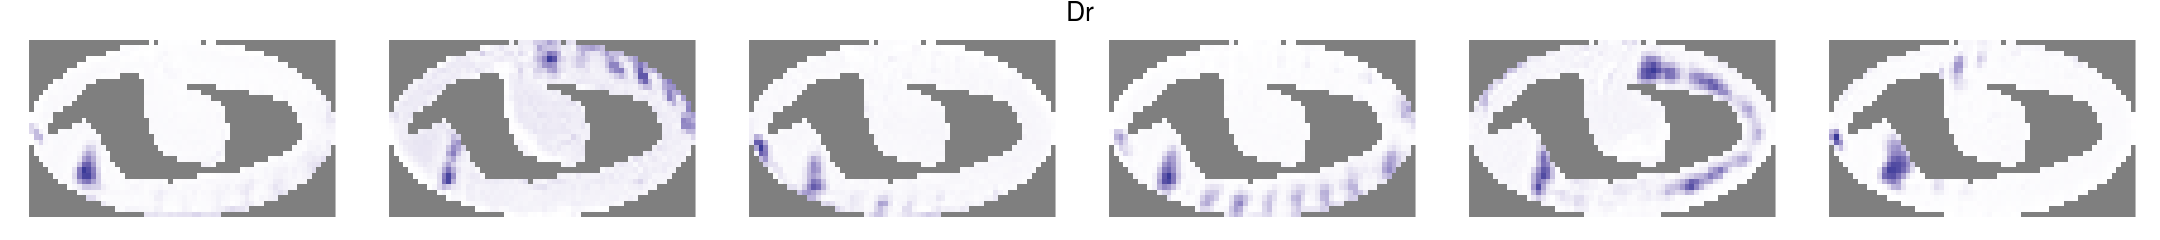

In [17]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 6){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 18, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


# Fix gene images according to recommendations by Erwin

There are a few possibilities: 

* The image was out of focus, and does not represent a real expression pattern; remove these replicates 

* For some genes, the expression of each replicate only captured a subset of the the true expression pattern; so here, we take either the max or average of the replicates

* The gene is actually dynamic in the late stage, and the different replicates were taken at slightly different points in time; here, the difference in replicates represent real variation. We append a letter "_a", "_b", "_c", etc and treat the replicates as different genes

In [18]:
# we store the clean images in clean_x
# keep only those which were not problematic
clean_x <- late$x[,  !(late$gene.names %in% which_problematic)]

In [19]:
dim(clean_x)

[1] 1143  601

### we go through each problematic gene, and apply Erwin's recommendation 

In [20]:
# keep only one of the replicates for this gene
keepOneReplicate <- function(gene.name, keep_indx){
    clean_x <- cbind(clean_x, late$x[, late$gene.names == gene.name][, keep_indx])
    colnames(clean_x)[dim(clean_x)[2]] <- gene.name
    
    return(clean_x)
}

In [21]:
# replicates correspond to distinct patterns, and append "_a", "_b", ... 
# to label these distinct patterns
labelDistinctReplicates <- function(gene.name){
    foo <- late$x[, late$gene.names == gene.name]
    
    n_replicates <- dim(foo)[2]
    
    colnames(foo) <- paste(gene.name,
                           letters[1:n_replicates], 
                           sep = '_')
    
    return(cbind(clean_x, foo))
}

In [22]:
# take max of all replicates
createMaxedReplicate <- function(gene.name){
    foo <- late$x[, late$gene.names == gene.name]
    clean_x <- cbind(clean_x, apply(foo, 1, max))

    colnames(clean_x)[dim(clean_x)[2]] <- gene.name
    
    return(clean_x)
}


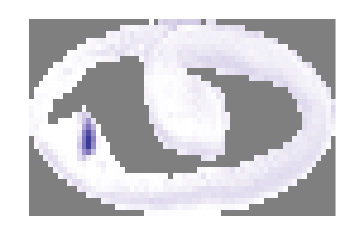

In [23]:
clean_x <- keepOneReplicate('Aldh', 2)

options(repr.plot.width = 3, repr.plot.height = 2)
plotImg(clean_x[, colnames(clean_x) == 'Aldh'], late$template, FALSE)    

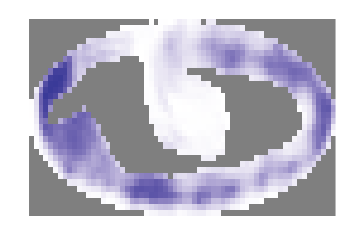

In [24]:
clean_x <- keepOneReplicate('Alhambra', 2)

plotImg(clean_x[, colnames(clean_x) == 'Alhambra'], late$template, FALSE)    

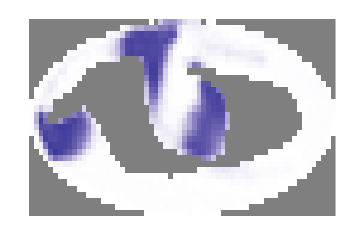

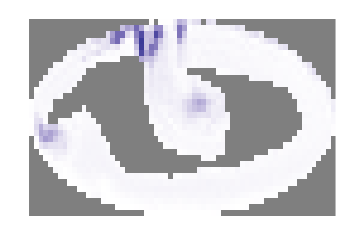

In [25]:
clean_x <- labelDistinctReplicates('Ance')

plotImg(clean_x[, colnames(clean_x) == 'Ance_a'], late$template, FALSE)    
plotImg(clean_x[, colnames(clean_x) == 'Ance_b'], late$template, FALSE)    

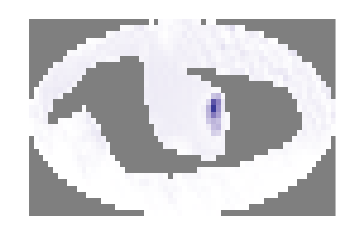

In [26]:
clean_x <- keepOneReplicate('aret', 2)

plotImg(clean_x[, colnames(clean_x) == 'aret'], late$template, FALSE)    

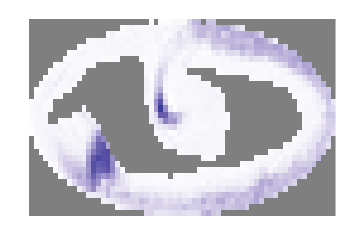

In [27]:
clean_x <- createMaxedReplicate('brk')

plotImg(clean_x[, colnames(clean_x) == 'brk'], late$template, FALSE)    

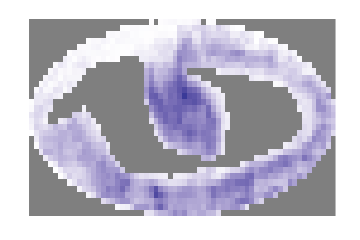

In [28]:
clean_x <- keepOneReplicate('CG10053', 2)

plotImg(clean_x[, colnames(clean_x) == 'CG10053'], late$template, FALSE)    

In [29]:
# CG12744 CG12909 CG1598 are OK
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG12744'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG12909'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG1598'])

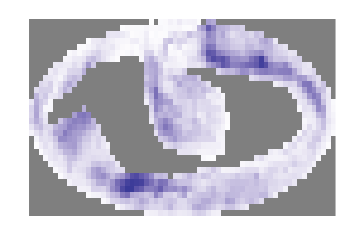

In [30]:
clean_x <- createMaxedReplicate('CG3184')
plotImg(clean_x[, colnames(clean_x) == 'CG3184'], late$template, FALSE)    

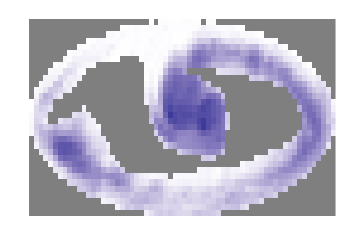

In [31]:
clean_x <- keepOneReplicate('CG3249', 1)
plotImg(clean_x[, colnames(clean_x) == 'CG3249'], late$template, FALSE)    

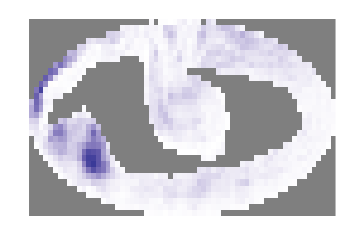

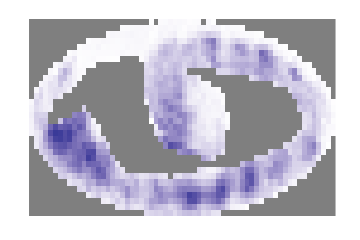

In [32]:
clean_x <- labelDistinctReplicates('CG3838')
plotImg(clean_x[, colnames(clean_x) == 'CG3838_a'], late$template, FALSE)    
plotImg(clean_x[, colnames(clean_x) == 'CG3838_b'], late$template, FALSE)

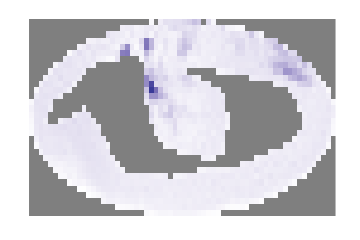

In [33]:
clean_x <- createMaxedReplicate('CG5888')
plotImg(clean_x[, colnames(clean_x) == 'CG5888'], late$template, FALSE)    

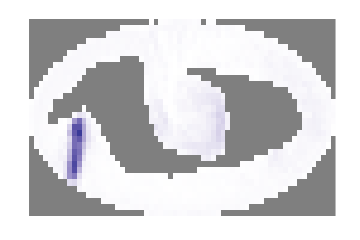

In [34]:
clean_x <- keepOneReplicate('CG6070', 2)
plotImg(clean_x[, colnames(clean_x) == 'CG6070'], late$template, FALSE)    

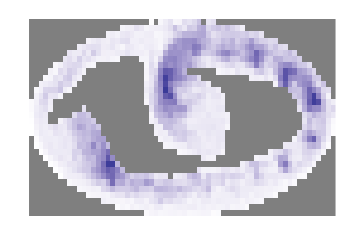

In [35]:
clean_x <- createMaxedReplicate('CG6206')
plotImg(clean_x[, colnames(clean_x) == 'CG6206'], late$template, FALSE)    

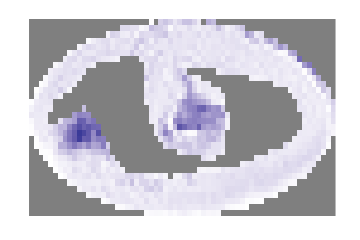

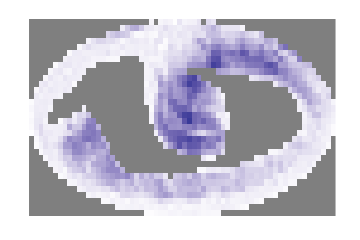

In [36]:
clean_x <- labelDistinctReplicates('CG6563')
plotImg(clean_x[, colnames(clean_x) == 'CG6563_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'CG6563_b'], late$template, FALSE)

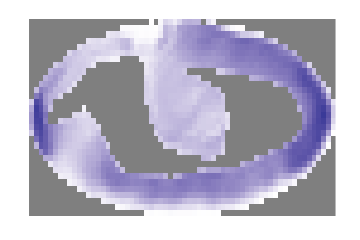

In [37]:
clean_x <- keepOneReplicate('cic', 2)

plotImg(clean_x[, colnames(clean_x) == 'cic'], late$template, FALSE)    

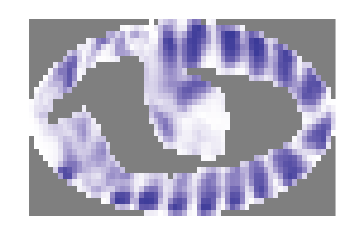

In [38]:
clean_x <- keepOneReplicate('comm2', 2)

plotImg(clean_x[, colnames(clean_x) == 'comm2'], late$template, FALSE)    

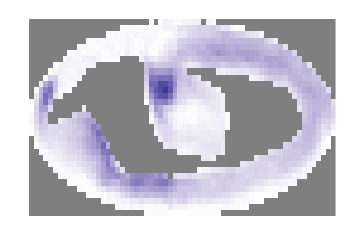

In [39]:
clean_x <- keepOneReplicate('disco', 2)

plotImg(clean_x[, colnames(clean_x) == 'disco'], late$template, FALSE)    

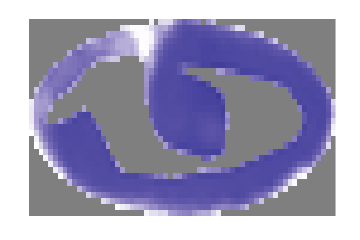

In [40]:
clean_x <- createMaxedReplicate('Dp')

plotImg(clean_x[, colnames(clean_x) == 'Dp'], late$template, FALSE)    

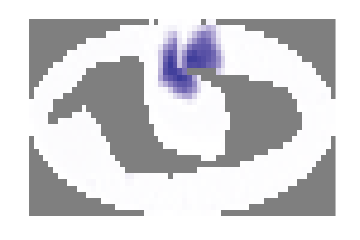

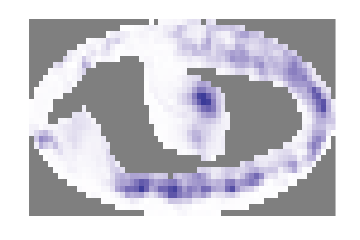

In [41]:
clean_x <- labelDistinctReplicates('dpn')
plotImg(clean_x[, colnames(clean_x) == 'dpn_a'], late$template, FALSE)   
plotImg(clean_x[, colnames(clean_x) == 'dpn_b'], late$template, FALSE)

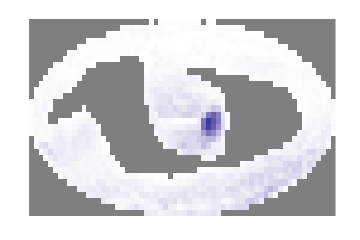

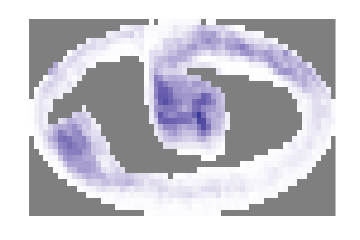

In [42]:
clean_x <- labelDistinctReplicates('ebi')
plotImg(clean_x[, colnames(clean_x) == 'ebi_a'], late$template, FALSE)   
plotImg(clean_x[, colnames(clean_x) == 'ebi_b'], late$template, FALSE)

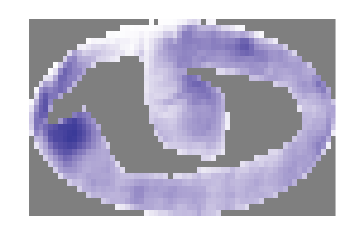

In [43]:
clean_x <- createMaxedReplicate('E(spl)')
plotImg(clean_x[, colnames(clean_x) == 'E(spl)'], late$template, FALSE)    

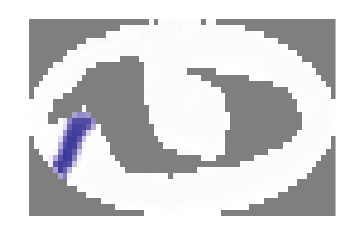

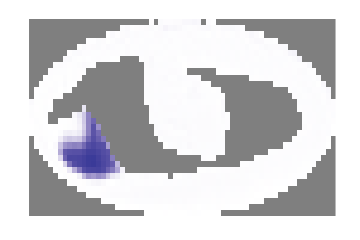

In [44]:
clean_x <- labelDistinctReplicates('gcm')
plotImg(clean_x[, colnames(clean_x) == 'gcm_a'], late$template, FALSE)    
plotImg(clean_x[, colnames(clean_x) == 'gcm_b'], late$template, FALSE)    

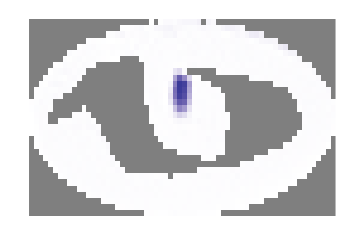

In [45]:
clean_x <- keepOneReplicate('Grip', 2)
plotImg(clean_x[, colnames(clean_x) == 'Grip'], late$template, FALSE)    

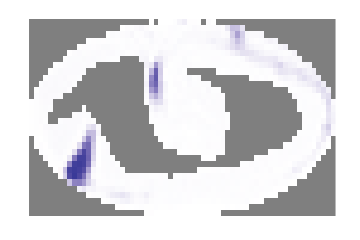

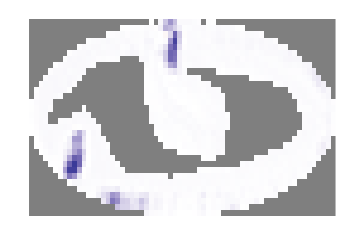

In [46]:
clean_x <- labelDistinctReplicates('HGTX')
plotImg(clean_x[, colnames(clean_x) == 'HGTX_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'HGTX_b'], late$template, FALSE)    

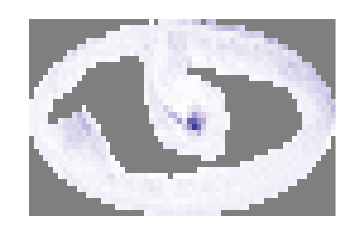

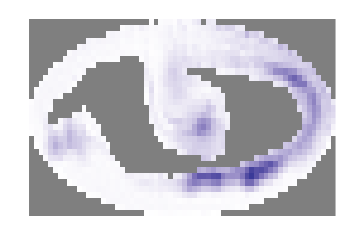

In [47]:
clean_x <- labelDistinctReplicates('l(3)82Fd')
plotImg(clean_x[, colnames(clean_x) == 'l(3)82Fd_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'l(3)82Fd_b'], late$template, FALSE)    

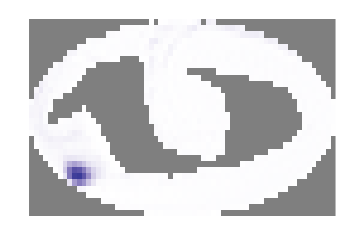

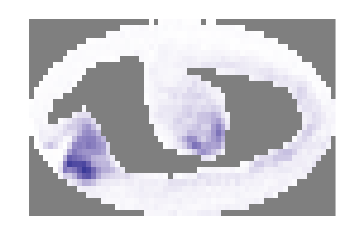

In [48]:
clean_x <- labelDistinctReplicates('lab')
plotImg(clean_x[, colnames(clean_x) == 'lab_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'lab_b'], late$template, FALSE)    

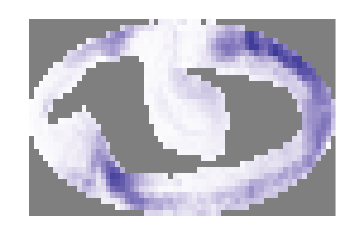

In [49]:
clean_x <- createMaxedReplicate('loner')
plotImg(clean_x[, colnames(clean_x) == 'loner'], late$template, FALSE)    

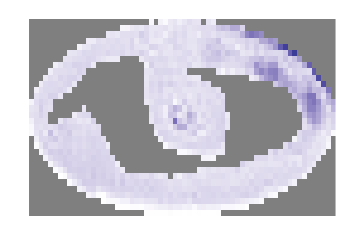

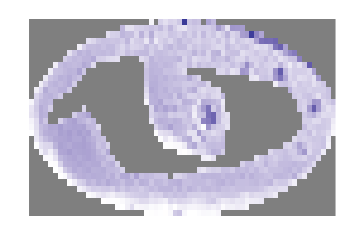

In [50]:
clean_x <- labelDistinctReplicates('mael')
plotImg(clean_x[, colnames(clean_x) == 'mael_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'mael_b'], late$template, FALSE)    

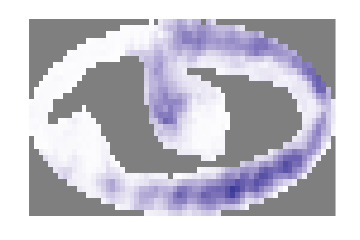

In [51]:
clean_x <- createMaxedReplicate('Mipp1')
plotImg(clean_x[, colnames(clean_x) == 'Mipp1'], late$template, FALSE)    

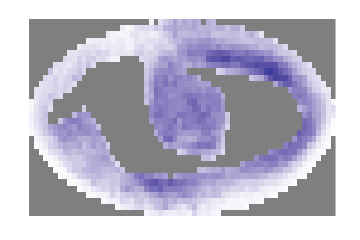

In [52]:
clean_x <- createMaxedReplicate('Nap1')
plotImg(clean_x[, colnames(clean_x) == 'Nap1'], late$template, FALSE)    

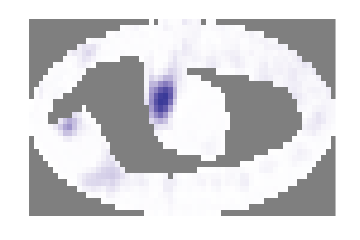

In [53]:
clean_x <- createMaxedReplicate('noc')
plotImg(clean_x[, colnames(clean_x) == 'noc'], late$template, FALSE)    

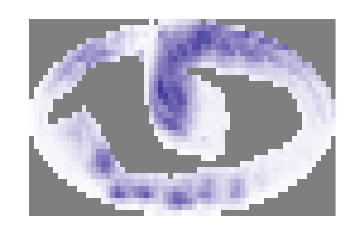

In [54]:
clean_x <- createMaxedReplicate('nrv2')
plotImg(clean_x[, colnames(clean_x) == 'nrv2'], late$template, FALSE)    

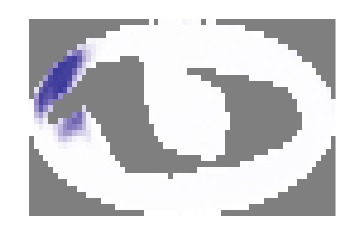

In [55]:
clean_x <- keepOneReplicate('Optix', 2)
plotImg(clean_x[, colnames(clean_x) == 'Optix'], late$template, FALSE)    

In [56]:
# pnt is OK
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'pnt'])

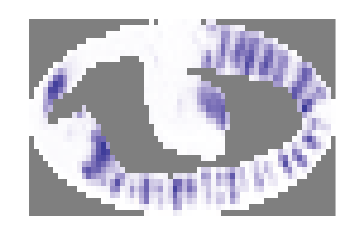

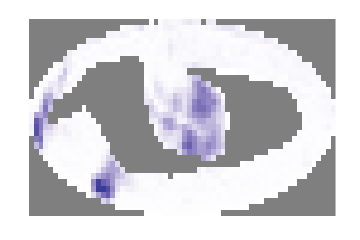

In [57]:
clean_x <- labelDistinctReplicates('sc')
plotImg(clean_x[, colnames(clean_x) == 'sc_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'sc_b'], late$template, FALSE)    

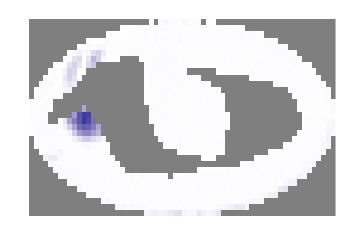

In [58]:
clean_x <- keepOneReplicate('toy', 1)
plotImg(clean_x[, colnames(clean_x) == 'toy'], late$template, FALSE)    

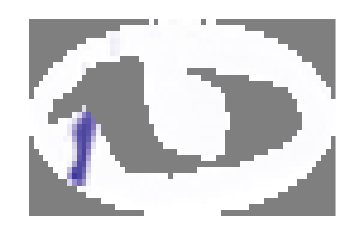

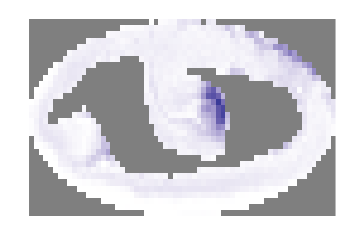

In [59]:
clean_x <- labelDistinctReplicates('ttk')
plotImg(clean_x[, colnames(clean_x) == 'ttk_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'ttk_b'], late$template, FALSE)    

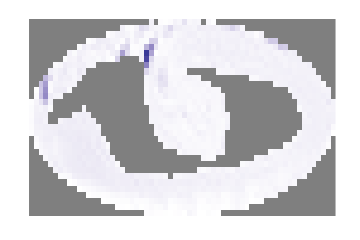

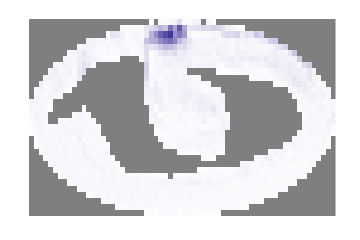

In [60]:
clean_x <- labelDistinctReplicates('tup')
plotImg(clean_x[, colnames(clean_x) == 'tup_a'], late$template, FALSE)
plotImg(clean_x[, colnames(clean_x) == 'tup_b'], late$template, FALSE)    

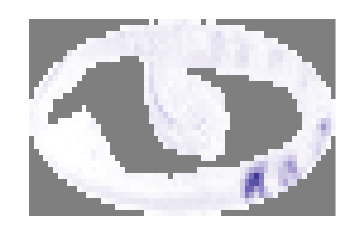

In [61]:
clean_x <- createMaxedReplicate('Ubx')
plotImg(clean_x[, colnames(clean_x) == 'Ubx'], late$template, FALSE)    

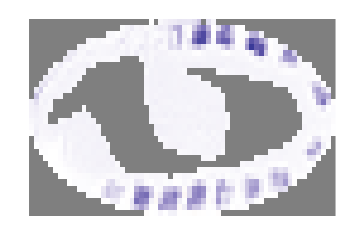

In [62]:
clean_x <- keepOneReplicate('unpg', 1)

plotImg(clean_x[, colnames(clean_x) == 'unpg'], late$template, FALSE)    

### These now have three replicates

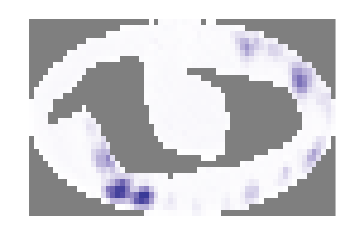

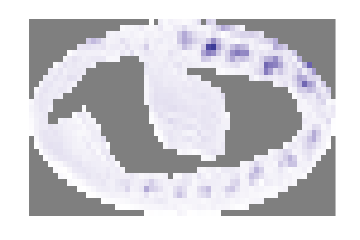

In [63]:
foo <- late$x[, late$gene.names == 'CG12489']

# max of first two, third is distinct
foo2 <- cbind(apply(foo[, c(1, 2)], 1, max), foo[, 3])

colnames(foo2) <- c('CG12489_a', 'CG12489_b')

clean_x <- cbind(clean_x, foo2)

plotImg(clean_x[, colnames(clean_x) == 'CG12489_a'], late$template, FALSE)   
plotImg(clean_x[, colnames(clean_x) == 'CG12489_b'], late$template, FALSE)    

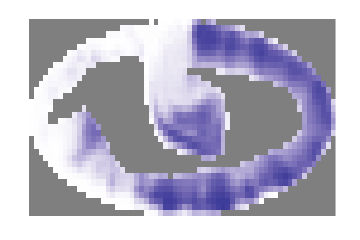

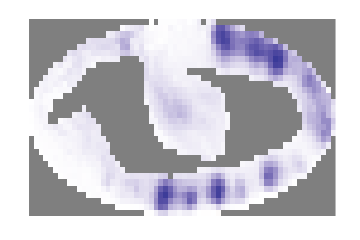

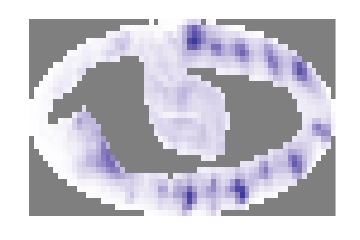

In [64]:
clean_x <- labelDistinctReplicates('CG13624')

plotImg(clean_x[, colnames(clean_x) == 'CG13624_a'], late$template, FALSE)   
plotImg(clean_x[, colnames(clean_x) == 'CG13624_b'], late$template, FALSE)    
plotImg(clean_x[, colnames(clean_x) == 'CG13624_c'], late$template, FALSE)

In [65]:
# keep two replicates
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG8066'][, c(1, 2)])

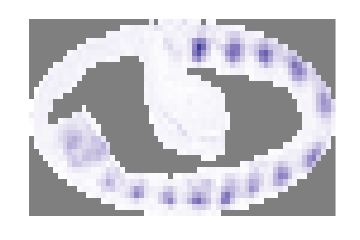

In [66]:
clean_x <- keepOneReplicate('CG9663', 2)

plotImg(clean_x[, colnames(clean_x) == 'CG9663'], late$template, FALSE)    

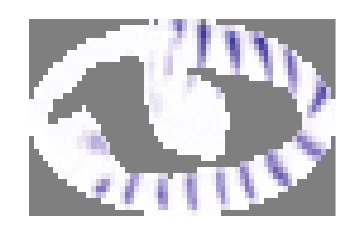

In [67]:
clean_x <- keepOneReplicate('en', 2)

plotImg(clean_x[, colnames(clean_x) == 'en'], late$template, FALSE)    

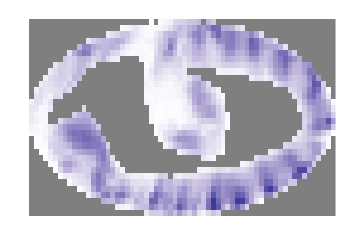

In [68]:
clean_x <- createMaxedReplicate('esg')
plotImg(clean_x[, colnames(clean_x) == 'esg'], late$template, FALSE)    

In [69]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'ImpE2'][, c(1,2)])

In [70]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'inx2'][, c(1,2)])

In [71]:
clean_x <- keepOneReplicate('kni', 1)

In [72]:
clean_x <- keepOneReplicate('Lac', 1)

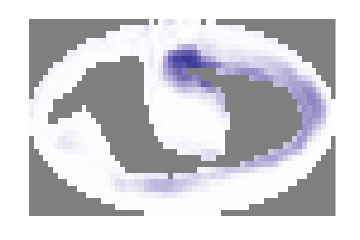

In [73]:
clean_x <- createMaxedReplicate('Mef2')

plotImg(clean_x[, colnames(clean_x) == 'Mef2'], late$template, FALSE)    

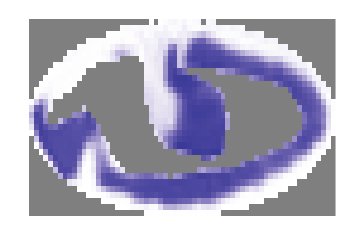

In [74]:
clean_x <- keepOneReplicate('Mes2', 2)

plotImg(clean_x[, colnames(clean_x) == 'Mes2'], late$template, FALSE)    

In [75]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'nerfin-1'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Oscillin'][, c(1,2)])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Pros54'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'slp1'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Sulf1'][, c(1, 3)])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'su(r)'][, c(1, 3)])

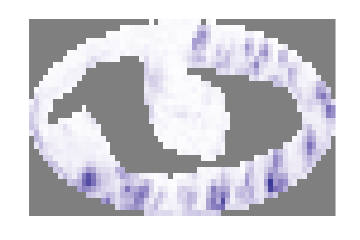

In [76]:
clean_x <- createMaxedReplicate('btn')

plotImg(clean_x[, colnames(clean_x) == 'btn'], late$template, FALSE)    

In [77]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG4854'][, c(1, 4)])

In [78]:
# one set with two replicates
foo <- late$x[, late$gene.names == 'eya'][, c(1, 3)]
colnames(foo) <- c('eya_a', 'eya_a')

# another set with two replicates
foo2 <- late$x[, late$gene.names == 'eya'][, c(2, 4)]
colnames(foo2) <- c('eya_b', 'eya_b')

clean_x <- cbind(clean_x, foo, foo2)

In [79]:
foo <- late$x[, late$gene.names == 'prd'][, c(1,2,3)]
colnames(foo) <- c('prd_a', 'prd_b', 'prd_c')
clean_x <- cbind(clean_x, foo)

In [80]:
foo <- late$x[, late$gene.names == 'srp']
colnames(foo) <- c('srp_a', 'srp_b', 'srp_b', 'srp_b')

clean_x <- cbind(clean_x, foo)

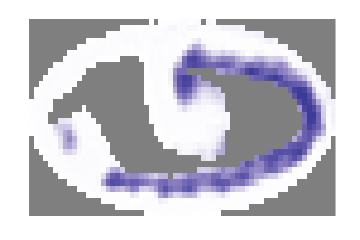

In [81]:
foo <- cbind(apply(late$x[, late$gene.names == 'twi'][, c(1, 3)], 1, max), 
             late$x[, late$gene.names == 'twi'][, 2])

colnames(foo) <- c('twi_a', 'twi_b')

clean_x <- cbind(clean_x, foo)

plotImg(clean_x[, colnames(clean_x) == 'twi_a'], late$template, FALSE)    

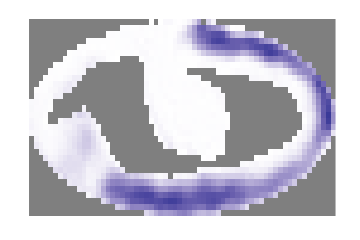

In [82]:
clean_x <- keepOneReplicate('HLHm5', 2)

plotImg(clean_x[, colnames(clean_x) == 'HLHm5'], late$template, FALSE)    

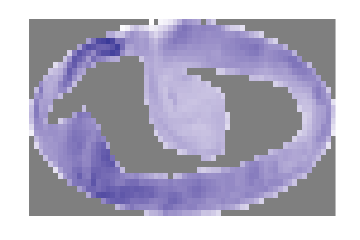

In [83]:
clean_x <- createMaxedReplicate('ind')

plotImg(clean_x[, colnames(clean_x) == 'ind'], late$template, FALSE)    

In [84]:
clean_x <- labelDistinctReplicates('otp')

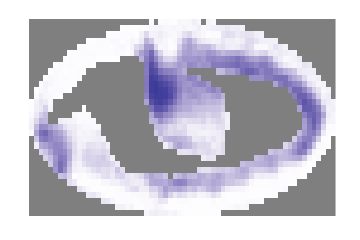

In [85]:
foo <- late$x[, late$gene.names == 'rib']
clean_x <- cbind(clean_x, apply(foo[, c(1, 2, 5)], 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'rib'

plotImg(clean_x[, colnames(clean_x) == 'rib'], late$template, FALSE)    

In [86]:
foo <- late$x[, late$gene.names == 'term']
colnames(foo) <- c('term_a', 'term_a', 'term_b', 'term_c', 'term_d')
clean_x <- cbind(clean_x, foo)

In [87]:
foo <- late$x[, late$gene.names == 'Dr']

foo1 <- apply(foo[, c(2, 4)], 1, max)
foo2 <- apply(foo[, c(3, 5)], 1, max)
foo3 <- foo[, c(1, 6)]

foo4 <- cbind(foo1, foo2, foo3)

colnames(foo4) <- c('Dr_a', 'Dr_b', 'Dr_c', 'Dr_c')
clean_x <- cbind(clean_x, foo4)

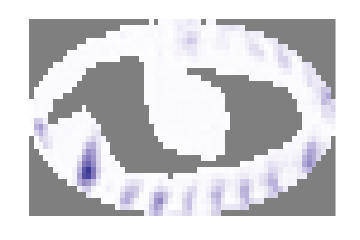

In [88]:
plotImg(clean_x[, colnames(clean_x) == 'Dr_a'], late$template, FALSE)    

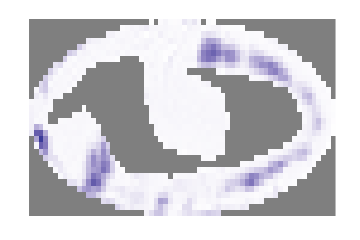

In [89]:
plotImg(clean_x[, colnames(clean_x) == 'Dr_b'], late$template, FALSE)    

In [90]:
dim(clean_x)

[1] 1143  726

In [91]:
dim(late$x)

[1] 1143  796

In [96]:
write.csv(clean_x, file = '../data/clean_x_tmp.csv')

In [100]:
tmp = read.csv('../data/clean_x.csv')[, -1]

In [117]:
tmp

pnr,CG11648,CG10645,Mkp3,Mkp3.1,CG8896,Sop2,CG1829,CG11755,CG11755.1,⋯,rib,term_1,term_1.1,term_2,term_3,term_4,Dr_1,Dr_2,Dr_3,Dr_3.1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0039630550,0.004223997,0.006402445,0.002924427,0.004632430,0.050408610,0.02957311,0.0034098925,0.006774806,0.005994517,⋯,0.002335469,0.006509191,0.002778123,0.007764825,0.006784510,0.003153192,1.338076e-02,0.012195690,1.320384e-03,0.003382202
0.0060456886,0.004542047,0.019160947,0.007962229,0.014104504,0.161436093,0.03393068,0.0060619895,0.017129272,0.007518649,⋯,0.009025642,0.020799027,0.007789094,0.014692734,0.008593044,0.006452615,7.166801e-03,0.019982861,1.374873e-03,0.001850151
0.0054522327,0.020213300,0.018448030,0.008625749,0.027178681,0.222187984,0.02441290,0.0081143010,0.034357325,0.011085709,⋯,0.024222999,0.024876797,0.007462156,0.023054019,0.009328059,0.008706858,2.409193e-03,0.021157688,9.124823e-02,0.021058827
0.0022809579,0.015884673,0.009898576,0.005467672,0.034513683,0.141860575,0.01134189,0.0055140561,0.032287933,0.008915868,⋯,0.047011264,0.029796870,0.008509974,0.023378618,0.005384333,0.008584032,1.231702e-02,0.023115564,8.311152e-02,0.205831668
0.0004454182,0.004466016,0.014309744,0.003715317,0.031632555,0.016492580,0.02535188,0.0026885911,0.012276872,0.004497089,⋯,0.057177066,0.031017941,0.005994635,0.024277040,0.008164830,0.006408857,4.574497e-03,0.025651394,-1.793867e-03,0.339714944
0.0005468421,0.003780794,0.012476317,0.001292807,0.020955466,0.003151919,0.01369161,-0.0003964828,0.002647749,0.002183655,⋯,0.021009745,0.018861970,0.005734164,0.021070742,0.003015780,0.003851164,-1.496427e-04,0.036827975,-9.970283e-04,0.104010357
0.0025913574,0.004617139,0.022769979,0.003949459,0.008421684,0.031311878,0.10643481,0.0218553959,0.010199437,0.018056860,⋯,0.004706500,0.007804118,0.005738473,0.007526488,0.017616090,0.003089666,5.794407e-03,0.014804196,1.035462e-05,0.007552981
0.0117244289,0.006077421,0.073431134,0.009539555,0.022307120,0.335043376,0.11231756,0.0292586013,0.041283250,0.014424709,⋯,0.017145508,0.032688700,0.005357655,0.013630762,0.017349297,0.007911632,9.781171e-03,0.030449798,2.093125e-03,0.014713044
0.0160129354,0.005143203,0.104941614,0.013284184,0.029292406,0.601722819,0.11767489,0.0353482552,0.047275425,0.014345782,⋯,0.046146612,0.068983399,0.008763149,0.017471762,0.008501297,0.009134505,1.989675e-02,0.014619945,4.392635e-03,0.017513501


In [111]:
?where

In [93]:
which(late$gene.names == 'eya')

159 160 161 162

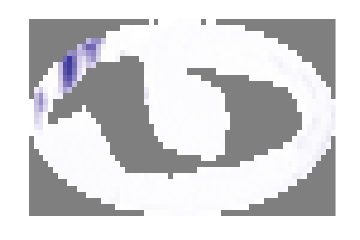

In [94]:
plotImg(late$x[, 159], late$template, FALSE)    

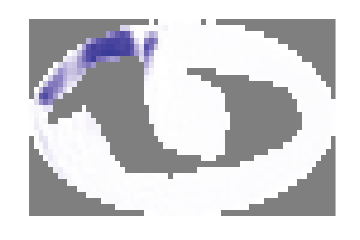

In [95]:
plotImg(late$x[, 161], late$template, FALSE)    